In [1]:
from qiskit import *
from qiskit.exceptions import QiskitError
import math
from qiskit.qasm.qasm import Qasm
from qiskit.converters import ast_to_dag
from qiskit.dagcircuit import DAGCircuit
from qiskit.qasm.qasmparser import QasmParser
from qiskit.qasm.exceptions import QasmError
import numpy as np

#from qiskit.qasm.qasmparser3 import QasmParser3
warnings.filterwarnings('ignore')

In [2]:
class Simple_Qasm3_converter:
  """
  This function support QASM 3.0 code with stdgates.inc to create a simple circuit in qiskit

  However, it just supports gates such  X, Y, Z, RX, RY, RZ, H, S, S†, T, T†, CX, CCX, SWAP & CSWAP.

  It doesn't support custom gate.

  The for loop and if command in Qasm3.0 cannot be converted in this function.

  Also pi variable in QASM3.0 cannot work

  Basic supporting form:

  qasm_1 = '''/* This a QASM 3.0 Code.\n It can be converted into qiskit using this class*/ 
  OPENQASM 3.0;
  include "stdgates.inc";
  qubit[3] q;
  qubit[1] a;
  bit[3] c;
  bit ca;
  x q;
  s q;
  y q[0];
  cx q[0] q[2];// cnot gate 
  swap q[0] q[1];
  ccx q[0] q[1] q[2];// toffoli gate 
  ry(1.5) q; 
  cswap q[0] q[1] q[2];
  rx(1.3) a; 
  cx a q[0];  
  measure q -> c; 
  ca = measure a;'''

  Or, you can input QASM3.0 file.

  """

  def __init__(self, code_data = None, file_title = None):

    qasm_object = Qasm(data=code_data,filename=file_title)

    if qasm_object._filename:

      with open(qasm_object._filename) as ifile:

        self.data = ifile.read() # read data

    else:

      self.data = qasm_object._data

  def Qasm3_2_qiskit_circuit(self):

    self.head = None # Make sure header is declared

    self.qasm_code = self.data.split('\n') # Make coding lines as list

    self.Total_line = len(self.qasm_code) # The total line of code

    self.qr = None # Make sure whether quantum bit is declared or not

    self.qr_dict = {} # To save varibles of quantum bit 

    self.cr = None # Make sure whether quantum bit is declared or not

    self.cr_dict = {} # To save varibles of classical bit 

    self.lib = None # Make sure library 

    self.non_lib_operation = ['reset'] 

    self.measurement = ['measure'] 

    self.QASM_operation = []

    self.lib_no_param_single_qubit = []

    self.lib_no_param_two_qubit = []

    self.lib_no_param_three_qubit = []

    self.lib_param_sing_qubit = []

    self.note_sign = False # To avoid note sign /* .......*/

    line = 0

    while line < self.Total_line:

      if self.qasm_code[line].replace(' ','') and not self.note_sign: # Make sure there are something in a code line

        qasm_line = self.qasm_code[line]

        if  qasm_line.replace(' ','')[:2]=='//': # if first two word is '//', this line is just a note and unreadable. 

          line=line+1

          continue

        elif qasm_line.replace(' ','')[:2]=='/*': # if first two word is '/*', this line is just a note and unreadable. 

          while self.qasm_code[line].replace(' ','')[-2:] != '*/': # next few lines is also unreadable until last two character is '*/'

            line=line+1

          line=line+1

        elif qasm_line.replace(' ','')[-1] !=';' :

          if '//' in qasm_line:

            code, note = qasm_line.split('//')

            if code.replace(' ','')[-1] != ';':

              raise QasmError("invalid syntax")

          elif '/*' in qasm_line:

            code, note = qasm_line.split('/*')

            if code.replace(' ','')[-1] != ';':

              raise QasmError("invalid syntax")

            self.note_sign = True

          else:

            raise QasmError("invalid syntax")

        qasm_line = self.qasm_code[line]

        qasm_line = qasm_line.replace(';','')
        
        if qasm_line.split()[:2]==['OPENQASM','3.0']:

          self.head=['OPENQASM',3.0]

        elif qasm_line.split()[:2]==['include','"stdgates.inc"']:

            # loading gate

          if self.head:

            self.lib_no_param_single_qubit = ['x','y','z','h','s','sdg','t','tdg']

            self.lib_no_param_two_qubit = ['cx','swap']

            self.lib_no_param_three_qubit = ['cswap','ccx']

            self.lib_param_sing_qubit = ['rx','ry','rz']

            self.lib=True

          else:

            raise QasmError("No header or the header is not defined well") 

        elif len(qasm_line)>=1 and qasm_line.split()[0][:5]=='qubit':

          if self.head:

            qasm_word_list = qasm_line.split()

            if len(qasm_word_list[0]) > 5:

              if len(qasm_word_list[0]) < 8 or qasm_word_list[0][5] != '[' or qasm_word_list[0][-1] != ']':

                raise QasmError("Invalid syntax")

              self.qr = True # qubit declaration

              self.qr_dict[qasm_line.split()[1]]=int(qasm_line.split()[0][6:-1])

            
            if len(qasm_word_list[0]) == 5:

              self.qr = True

              self.qr_dict[qasm_line.split()[1]] = 1 # Record qubit varible as key and the corresponding number of qubit as the item
          
          else:

            raise QasmError("No header or the header is not defined well") 

        elif len(qasm_line)>=1 and qasm_line.split()[0][:3]=='bit':

          if self.head:

            qasm_word_list = qasm_line.split()

            if len(qasm_word_list[0]) > 3:

              if len(qasm_word_list[0]) < 6 or qasm_word_list[0][3] != '[' or qasm_word_list[0][-1] != ']':

                raise QasmError("Invalid syntax")

              self.cr = True # qubit declaration

              self.cr_dict[qasm_word_list[1]]=int(qasm_word_list[0][4:-1])

            # Record the qubit variable
            if len(qasm_word_list[0]) == 3:

              self.cr = True

              self.cr_dict[qasm_word_list[1]] = 1

          else:

            raise QasmError("No header or the header is not defined well") 
        
        elif len(qasm_line.split()) >= 2:

          # The code
          qasm_word_list = qasm_line.split()

          if not self.head:

            raise QasmError("No header or the header is not defined well") 

          if self.qr:

            if qasm_word_list[0] in self.non_lib_operation:

              qubit_1 = self.varq(qasm_word_list[1])

              self.QASM_operation.append((qasm_word_list[0],qubit_1))

            elif qasm_word_list[0] in self.measurement:

              if '->' not in qasm_line:

                raise QasmError("Invalid syntax")

              else:

                first_part, second_part = qasm_line.split('->')

                meas, q_v = first_part.split()

                c_v = second_part.replace('//',' ').replace('/*',' ').split()[0]

                qubits = self.varq(q_v)

                bits = self.varc(c_v)

                self.QASM_operation.append((meas, qubits, bits))

            elif qasm_line.split('=')[0].replace(' ','') in self.cr_dict:

              c_v, meas_q_v = qasm_line.split('=')

              meas, q_v = meas_q_v.split()

              #meas = meas.replace(' ','')

              #q_v = q_v.replace(' ','')

              if meas not in self.measurement:

                raise QasmError(meas+" is not defined.")

              qubits = self.varq(q_v)

              bits = self.varc(c_v)

              self.QASM_operation.append((meas, qubits, bits))

            elif self.lib:

              if qasm_word_list[0] in self.lib_no_param_single_qubit:

                qubit_1 = self.varq(qasm_word_list[1])

                self.QASM_operation.append((qasm_word_list[0],qubit_1))

              elif qasm_word_list[0] in self.lib_no_param_two_qubit:

                qubit_1 = self.varq(qasm_word_list[1])

                qubit_2 = self.varq(qasm_word_list[2])

                self.QASM_operation.append((qasm_word_list[0],qubit_1,qubit_2))

              elif qasm_word_list[0] in self.lib_no_param_three_qubit:

                qubit_1 = self.varq(qasm_word_list[1])

                qubit_2 = self.varq(qasm_word_list[2])

                qubit_3 = self.varq(qasm_word_list[3])

                self.QASM_operation.append((qasm_word_list[0],qubit_1,qubit_2,qubit_3))

              elif qasm_word_list[0][:2] in self.lib_param_sing_qubit:

                if len(qasm_word_list[0]) < 5 or qasm_word_list[0][2] != '(' or qasm_word_list[0][-1] != ')':

                  raise QasmError("Invalid syntax")

                else :

                  qubit_1 = self.varq(qasm_word_list[1])

                  self.QASM_operation.append((qasm_word_list[0][:2],qasm_word_list[0][3:-1],qubit_1))

              else:

                raise QasmError("This interpreter only support X, Y, Z, RX, RY, RZ, H, S, S†, T, T†, CX, CCX, SWAP & CSWAP\n"+"in stdgates.inc")

      if self.note_sign and self.qasm_code[line].replace(' ','')[-2] == '*/':

        self.note_sign = False

      line=line+1

    return self.operation_to_circuit(self.QASM_operation)

  def varq(self,string_q):

    """
    Input: Quantum bit register variables' string  

    Output: Quantum bit register name, the correspond index of the qubit (can be list)

    """
    string_q =string_q.replace(' ', '')

    if '[' in string_q and ']' in string_q:

      var, indx =string_q.split('[')[:2]

      indx = indx.split(']')[0]

      if var not in self.qr_dict:

        raise QasmError("variable "+var+" is not defined.")

      if int(indx) >= int(self.qr_dict[var]):

        raise QasmError("The qubit index"+ indx+" out of list.")

      return (var,int(indx))

    else:

      var = string_q

      if var not in self.qr_dict:

        raise QasmError("variable "+var+" is not defined.")

      num_q = self.qr_dict[var]

      lst = [i for i in range(num_q)]

      if len(lst)==1:

        return (var,0)

      else:

        return (var,lst)

  # To identify classical bit variable and see whether it is declared or not.

  def varc(self,string_q): 

    """
    Input: Classical bit register variables' string  

    Output: classical bit register name, the correspond index of the bit (can be list)

    """
    string_q =string_q.replace(' ', '')

    if '[' in string_q and ']' in string_q:

      var, indx =string_q.split('[')[:2]

      indx = indx.split(']')[0]

      if var not in self.cr_dict:

        raise QasmError("variable "+var+" is not defined.")

      if ':' in indx:

        indx_list = indx.split(':')

        if len(indx_list) == 2:

          if indx_list[0]:

            start = indx_list[0]

          else:

            start = 0

          if indx_list[1]:

            end = int(indx_list[1])

          else:

            end = int(cr_dict[var])

        if len(indx_list) == 3:

          if indx_list[0]:

            start = int(indx_list[0])

            if start > cr_dict[var] and start <= -cr_dict[var]:

              raise QasmError("The qubit index "+ str(start)+" out of list.")

          else:

            start = 0

          if indx_list[1]:

            end = int(indx_list[1])

            if end > cr_dict[var] and end <= -cr_dict[var]:

              raise QasmError("The qubit index "+ str(end)+" out of list.")

          else:

            end = cr_dict[var]

          if indx_list[2]:

            step = int(indx_list[2])

          else:

            step = 1

          return (var, [k for k in range(start,end,step)])

      elif int(indx) >= int(self.cr_dict[var]):

        raise QasmError("The qubit index "+ indx+" out of list.")

      else:

        return (var,int(indx))

    else:

      var = string_q

      if var not in self.cr_dict:

        raise QasmError("variable "+var+" is not defined.")

      num_q = self.cr_dict[var]

      lst = [i for i in range(num_q)]

      if len(lst)==1:

        return (var,0)

      else:

        return (var,lst)

  def operation_to_circuit(self,operations): # To tranfer the operations into Qiskit circuit.

    """
    Input: the operation made by Qasm3_2_qiskit_circuit function

    """

    qr_key_list = self.qr_dict.keys()

    cr_key_list = self.cr_dict.keys()

    quantum_reg_list = []

    classical_reg_list = []

    var_to_list_index_q = {}

    var_to_list_index_c = {}

    for indx, var in enumerate(qr_key_list):

      quantum_reg_list.append(QuantumRegister(self.qr_dict[var],var))

      var_to_list_index_q[var]=indx

    for indx, var in enumerate(cr_key_list):

      classical_reg_list.append(ClassicalRegister(self.cr_dict[var],var))

      var_to_list_index_c[var]=indx

    qasm_circuit = QuantumCircuit(quantum_reg_list[0],classical_reg_list[0])

    reg_remain_list = quantum_reg_list[1:]+classical_reg_list[1:]

    for reg in reg_remain_list:

      qasm_circuit.add_register(reg)

    for operation in operations:

      if operation[0] == 'x':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q = operation[1][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            qasm_circuit.x(q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          qasm_circuit.x(q_1)

      elif operation[0] == 'y':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q = operation[1][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            qasm_circuit.y(q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          qasm_circuit.y(q_1)

      elif operation[0] == 'z':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q = operation[1][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            qasm_circuit.z(q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          qasm_circuit.z(q_1)

      elif operation[0] == 'h':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q = operation[1][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            qasm_circuit.h(q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          qasm_circuit.h(q_1)

      elif operation[0] == 's':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q = operation[1][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            qasm_circuit.s(q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          qasm_circuit.s(q_1)

      elif  operation[0] == 'sdg':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q = operation[1][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            qasm_circuit.sdg(q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          qasm_circuit.sdg(q_1)

      elif  operation[0] == 't':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q = operation[1][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            qasm_circuit.t(q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          qasm_circuit.t(q_1)

      elif  operation[0] == 'tdg':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q = operation[1][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            qasm_circuit.tdg(q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          qasm_circuit.tdg(q_1)

      elif  operation[0] == 'cx':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q_1 = operation[1][1]

        q_1 = quantum_reg_list[indx_1][i_q_1]

        var_2 = operation[2][0]

        indx_2 = var_to_list_index_q[var_2]

        i_q_2 = operation[2][1]

        q_2 = quantum_reg_list[indx_2][i_q_2]

        qasm_circuit.cx(q_1,q_2)

      elif  operation[0] == 'swap':

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q_1 = operation[1][1]

        q_1 = quantum_reg_list[indx_1][i_q_1]

        var_2 = operation[2][0]

        indx_2 = var_to_list_index_q[var_2]

        i_q_2 = operation[2][1]

        q_2 = quantum_reg_list[indx_2][i_q_2]

        qasm_circuit.swap(q_1,q_2)

      elif  operation[0] == 'cswap': 

        q_1 = quantum_reg_list[var_to_list_index_q[operation[1][0]]][operation[1][1]]

        q_2 = quantum_reg_list[var_to_list_index_q[operation[2][0]]][operation[2][1]]

        q_3 = quantum_reg_list[var_to_list_index_q[operation[3][0]]][operation[3][1]]

        qasm_circuit.cswap(q_1,q_2,q_3)

      elif  operation[0] == 'ccx': 

        q_1 = quantum_reg_list[var_to_list_index_q[operation[1][0]]][operation[1][1]]

        q_2 = quantum_reg_list[var_to_list_index_q[operation[2][0]]][operation[2][1]]

        q_3 = quantum_reg_list[var_to_list_index_q[operation[3][0]]][operation[3][1]]

        qasm_circuit.ccx(q_1,q_2,q_3)

      elif operation[0] == 'rx': # Rotation x gate

        var_1 = operation[2][0]

        indx_1 = var_to_list_index_q[var_1]

        par_1 = operation[1]

        i_q = operation[2][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            if par_1.isdigit() or par_1.replace('.','').isdigit():

              qasm_circuit.rx(float(par_1),q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          if par_1.isdigit() or par_1.replace('.','').isdigit():

            qasm_circuit.rx(float(par_1),q_1)

      elif operation[0] == 'ry': # Rotation Y gate

        var_1 = operation[2][0]

        indx_1 = var_to_list_index_q[var_1]

        par_1 = operation[1]

        i_q = operation[2][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            if par_1.isdigit() or par_1.replace('.','').isdigit():

              qasm_circuit.ry(float(par_1),q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          if par_1.isdigit() or par_1.replace('.','').isdigit():

            qasm_circuit.ry(float(par_1),q_1)

      elif operation[0] == 'rz': # Rotation Z gate

        var_1 = operation[2][0]

        indx_1 = var_to_list_index_q[var_1]

        par_1 = operation[1]

        i_q = operation[2][1]

        if type(i_q)== list:

          for q_index in i_q:

            q_1 = quantum_reg_list[indx_1][q_index]

            if par_1.isdigit() or par_1.replace('.','').isdigit():

              qasm_circuit.rz(float(par_1),q_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q]

          if par_1.isdigit() or par_1.replace('.','').isdigit():

            qasm_circuit.rz(float(par_1),q_1)

      elif operation[0] == 'reset': # Reset

        q_1 = quantum_reg_list[var_to_list_index_q[operation[1][0]]][operation[1][1]]

        qasm_circuit.reset(q_1)

      elif operation[0] == 'measure': # Measurement

        var_1 = operation[1][0]

        indx_1 = var_to_list_index_q[var_1]

        i_q_1 = operation[1][1]

        var_2 = operation[2][0]

        indx_2 = var_to_list_index_c[var_2]

        i_c_2 = operation[2][1]

        if type(i_q_1)==list:

           for i in range(len(i_q_1)):

             q_indx = i_q_1[i]

             c_indx = i_c_2[i]

             q_1 = quantum_reg_list[indx_1][q_indx]

             c_1 = classical_reg_list[indx_2][c_indx]

             qasm_circuit.measure(q_1,c_1)

        else:

          q_1 = quantum_reg_list[indx_1][i_q_1]

          c_1 = classical_reg_list[indx_2][i_c_2]

          qasm_circuit.measure(q_1,c_1)

    return qasm_circuit

  def Inverse_circuit(self):

    """

    Input: circuit without custom gate but with some basic gates

    Output: Inverse circuit  

    This function can found out the unitary of circuit using unitrary property (ABC)^{\dagger}=C^{\dagger}B^{\dagger}A^{\dagger}

    where ABC is the gate X, Y, Z, RX, RY, RZ, H, S, S†, T, T†, CX, CCX, SWAP & CSWAP.

    If the measurement is not in the end of circuit, the circuit is not an unitary. This function cannot work.
    """

    circuit = self.Qasm3_2_qiskit_circuit()
    
    # Make sure the type of input is circuit
    if type(circuit)!=qiskit.circuit.quantumcircuit.QuantumCircuit:

      raise QiskitError("The Type of input is not a circuit")

    X=qiskit.circuit.library.standard_gates.x.XGate

    Y=qiskit.circuit.library.standard_gates.y.YGate

    Z=qiskit.circuit.library.standard_gates.z.ZGate

    H=qiskit.circuit.library.standard_gates.h.HGate

    CX=qiskit.circuit.library.standard_gates.x.CXGate

    CCX=qiskit.circuit.library.standard_gates.x.CCXGate

    Swap=qiskit.circuit.library.standard_gates.swap.SwapGate

    CSwap=qiskit.circuit.library.standard_gates.swap.CSwapGate 

    Hermitian_gate = [X,Y,Z,H,CX,CCX,Swap,CSwap]

    RX = qiskit.circuit.library.standard_gates.rx.RXGate

    RY = qiskit.circuit.library.standard_gates.ry.RYGate

    RZ = qiskit.circuit.library.standard_gates.rz.RZGate

    Rotation_gate = [RX,RY,RZ]

    S = qiskit.circuit.library.standard_gates.s.SGate

    Sdg = qiskit.circuit.library.standard_gates.s.SdgGate

    T = qiskit.circuit.library.standard_gates.t.TGate

    Tdg = qiskit.circuit.library.standard_gates.t.TdgGate

    Non_Hermitian_gate = [S,Sdg,T,Tdg]

    Meas = qiskit.circuit.measure.Measure

    Inverse_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs)

    Detect_Meas_not_mid_cir={}

    for reg in circuit.qregs:

      Detect_Meas_not_mid_cir[reg]=[True]*reg.size

    Meas_qubit_cbit=[]

    for operation in circuit[::-1]:

      if type(operation[0]) in Hermitian_gate: # The gates without parameter and its inverse matrix is itself

        Inverse_cir.data.append(operation)

        if len(operation[1])==1:

          q_index = operation[1][0].index

          q_register = operation[1][0].register

          Detect_Meas_not_mid_cir[q_register][q_index] = False

        if len(operation[1])==2:

          q_index1 = operation[1][0].index

          q_register1 = operation[1][0].register

          q_index2 = operation[1][1].index

          q_register2 = operation[1][1].register

          Detect_Meas_not_mid_cir[q_register1][q_index1] = False

          Detect_Meas_not_mid_cir[q_register2][q_index2] = False

        if len(operation[1])==3:

          q_index1 = operation[1][0].index

          q_register1 = operation[1][0].register

          q_index2 = operation[1][1].index

          q_register2 = operation[1][1].register

          q_index3 = operation[1][2].index

          q_register3 = operation[1][2].register

          Detect_Meas_not_mid_cir[q_register1][q_index1] = False

          Detect_Meas_not_mid_cir[q_register2][q_index2] = False

          Detect_Meas_not_mid_cir[q_register3][q_index3] = False

      elif type(operation[0]) in Rotation_gate: # The gates with parameter

        if type(operation[0]) == RX:

          q_index = operation[1][0].index

          q_register = operation[1][0].register

          Inverse_cir.rx(-1*operation[0].params[0],q_register[q_index])

          Detect_Meas_not_mid_cir[q_register][q_index] = False

        elif type(operation[0]) == RY:

          q_index = operation[1][0].index

          q_register = operation[1][0].register

          Inverse_cir.ry(-1*operation[0].params[0],q_register[q_index])

          Detect_Meas_not_mid_cir[q_register][q_index] = False

        elif type(operation[0]) == RZ:

          q_index = operation[1][0].index

          q_register = operation[1][0].register

          Inverse_cir.rz(-1*operation[0].params[0],q_register[q_index])

          Detect_Meas_not_mid_cir[q_register][q_index] = False

      elif type(operation[0]) in Non_Hermitian_gate: # The gate have inverse gate not itself

        if type(operation[0]) == S:

          q_index = operation[1][0].index

          q_register = operation[1][0].register

          Inverse_cir.sdg(q_register[q_index])

          Detect_Meas_not_mid_cir[q_register][q_index] = False

        elif type(operation[0]) == Sdg:

          q_index = operation[1][0].index

          q_register = operation[1][0].register

          Inverse_cir.s(q_register[q_index])

          Detect_Meas_not_mid_cir[q_register][q_index] = False

        elif type(operation[0]) == T:

          q_index = operation[1][0].index

          q_register = operation[1][0].register

          Inverse_cir.tdg(q_register[q_index])

          Detect_Meas_not_mid_cir[q_register][q_index] = False

        elif type(operation[0]) == Tdg:

          q_index = operation[1][0].index

          q_register = operation[1][0].register

          Inverse_cir.t(q_register[q_index])

          Detect_Meas_not_mid_cir[q_register][q_index] = False

      elif type(operation[0]) == Meas:

        q_bit = operation[1][0]

        c_bit = operation[2][0]

        if Detect_Meas_not_mid_cir[q_bit.register][q_bit.index]:

          Meas_qubit_cbit.append((q_bit,c_bit))

        else:

          raise QiskitError('Cannot inverse the circuit with measurement among the gates. The measurement should be after the gates')

    for mea in Meas_qubit_cbit[::-1]:

      q_i, c_i = mea

      Inverse_cir.measure(q_i,c_i)

    return Inverse_cir


In [3]:
qasm_1 = '''/* This a QASM 3.0 Code.\n It can be converted into qiskit using this class*/ \n OPENQASM 3.0;\n include "stdgates.inc";\n qubit[3] q;\n qubit[1] a;\n bit[3] c;\n bit ca;\n x q;\n s q;\n y q[0];\n cx q[0] q[2];// cnot gate \n \n swap q[0] q[1];\n ccx q[0] q[1] q[2];// toffoli gate \n ry(1.5) q; \n cswap q[0] q[1] q[2];\n rx(1.3) a; \n cx a q[0];  \n measure q -> c; \n ca = measure a;'''

In [4]:
qasm1=Simple_Qasm3_converter(code_data=qasm_1)

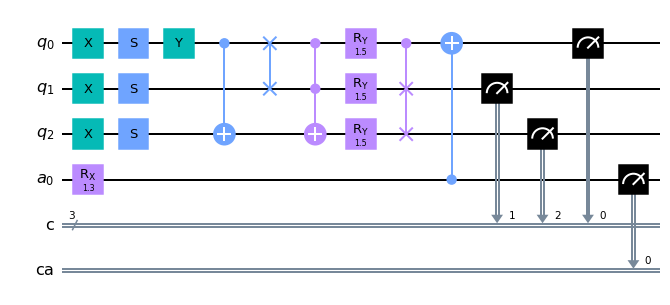

In [5]:
qasm1.Qasm3_2_qiskit_circuit().draw('mpl')

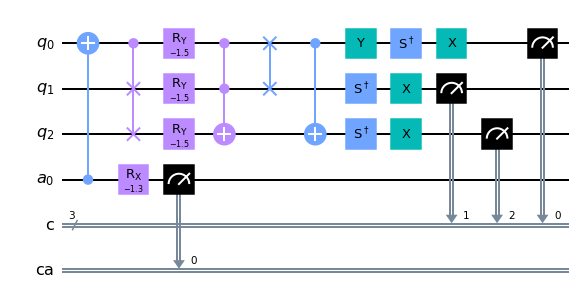

In [6]:
qasm1.Inverse_circuit().draw('mpl')